In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk

In [137]:
ID = 9635649
target = f'KIC {ID}'
tgt = f'KIC{ID}'


tpf = lk.search_targetpixelfile(f'{target}', mission='Kepler')
tpf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr009635649,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr009635649,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr009635649,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr009635649,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr009635649,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr009635649,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr009635649,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr009635649,0.0
8,Kepler Quarter 10,2011,Kepler,1800,kplr009635649,0.0


In [138]:
tpf_list = tpf.download_all(quality_bitmask='hard')

<Axes: title={'center': 'Pipeline Mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

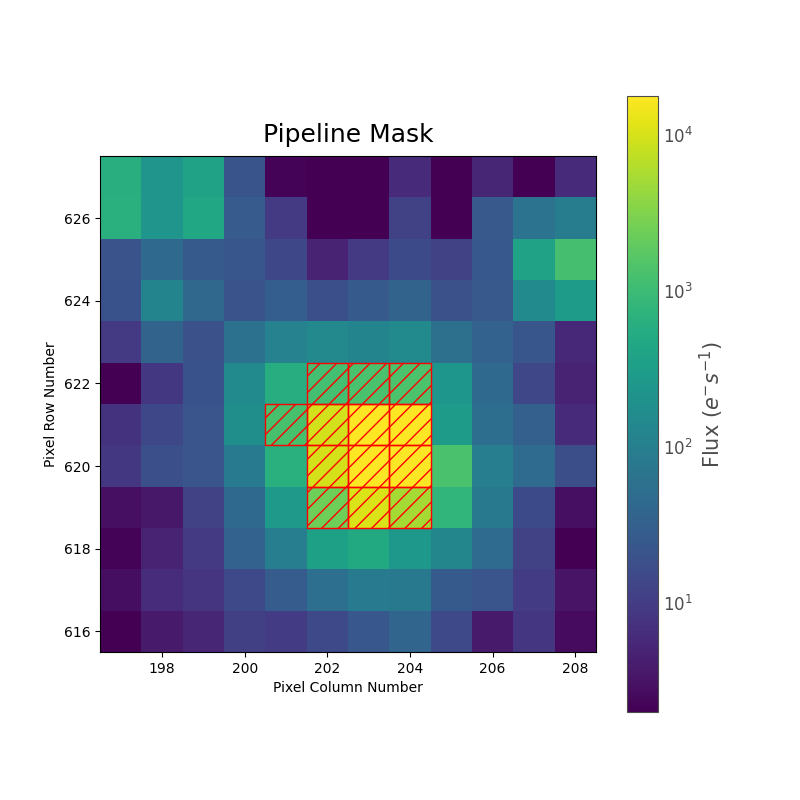

In [140]:
tpf_zero = tpf_list[0]
fig, ax = plt.subplots(1,1,figsize=(8,8))
tpf_zero.plot(ax=ax, aperture_mask=tpf_zero.pipeline_mask, title='Pipeline Mask', scale='log')

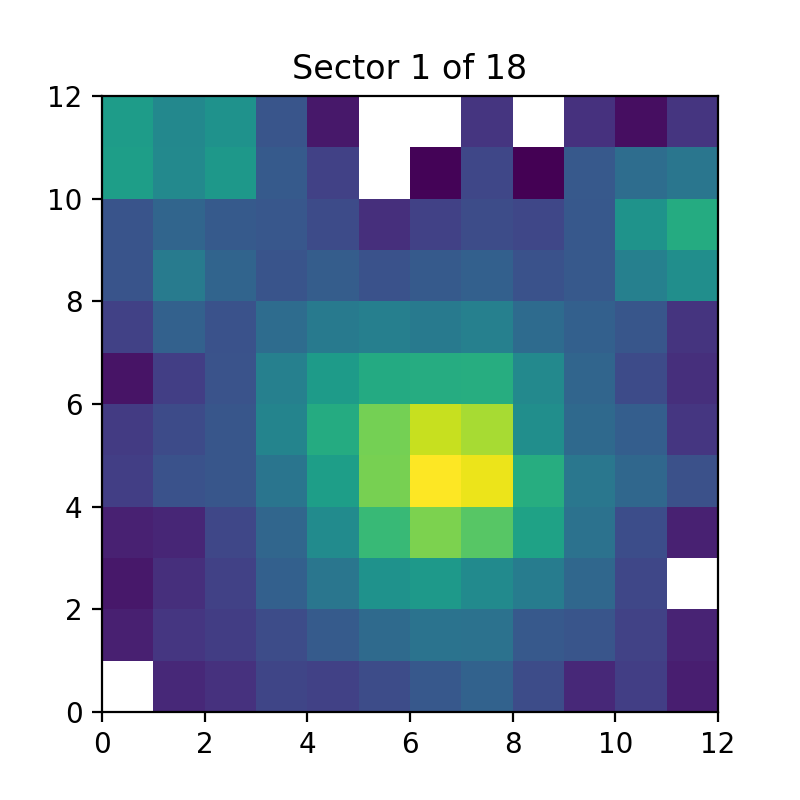

All sectors done.


In [141]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
%matplotlib widget

current_sector = 0
aper_masks = []
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

def show_sector(sector_idx):
    global aper_mask, flux_data, ny, nx

    tpf_file = tpf_list[sector_idx]
    flux_data = tpf_file.flux[0].value
    ny, nx = flux_data.shape
    aper_mask = np.zeros((ny, nx), dtype=bool)
    plot_aperture()

def plot_aperture():
    ax.clear()
    ax.imshow(flux_data, cmap='viridis', origin='lower',
              extent=(0, nx, 0, ny), norm=LogNorm())
    for y in range(ny):
        for x in range(nx):
            if aper_mask[y, x]:
                rect = patches.Rectangle((x, y), 1, 1,
                                         hatch='///', fill=False,
                                         edgecolor='red', linewidth=1.5)
                ax.add_patch(rect)
    ax.set_title(f"Sector {current_sector + 1} of {len(tpf_list)}")
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    plt.draw()

def on_click(event):
    if event.inaxes != ax:
        return
    x, y = int(np.floor(event.xdata)), int(np.floor(event.ydata))
    if 0 <= x < nx and 0 <= y < ny:
        aper_mask[y, x] = not aper_mask[y, x]
        plot_aperture()

def on_key(event):
    global current_sector

    if event.key == 'enter':
        aper_masks.append(aper_mask.copy())
        current_sector += 1
        if current_sector < len(tpf_list):
            show_sector(current_sector)
        else:
            print("All sectors done.")
            plt.close(fig)

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

# Start with first sector
show_sector(current_sector)
plt.show()


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

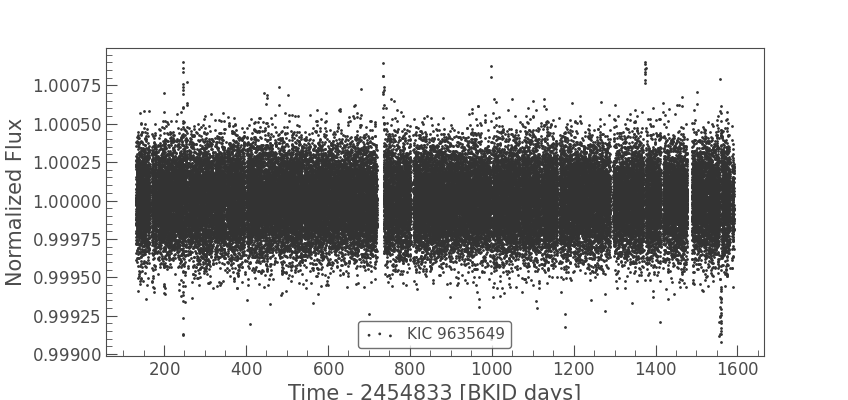

In [142]:
lightcurves = []
for tpf, mask in zip(tpf_list, aper_masks):
    lc = tpf.to_lightcurve(aperture_mask=mask)
    lightcurves.append(lc)

lc_all = lightcurves[0].append(lightcurves[1:])

lc = lc_all.flatten().remove_outliers(5)
lc.scatter()

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power'>

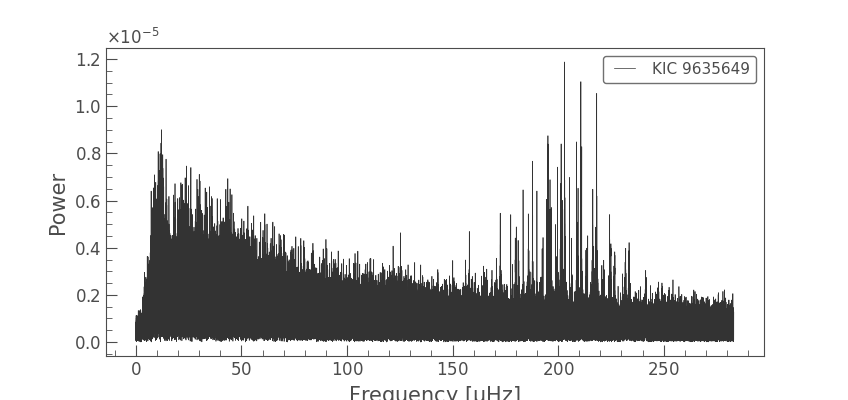

In [143]:
pg = lc.to_periodogram(freq_unit='microhertz')
pg.plot()

In [144]:
time = lc.time.value
flux = (lc.flux.value - 1) * 1e6 # parts-per-million
flux_err = lc.flux_err.value * 1e6 # parts-per-million

np.savetxt(f'{tgt}_lc.txt', np.column_stack([time, flux, flux_err]))

<Axes: xlabel='Time [JD]', ylabel='Flux'>

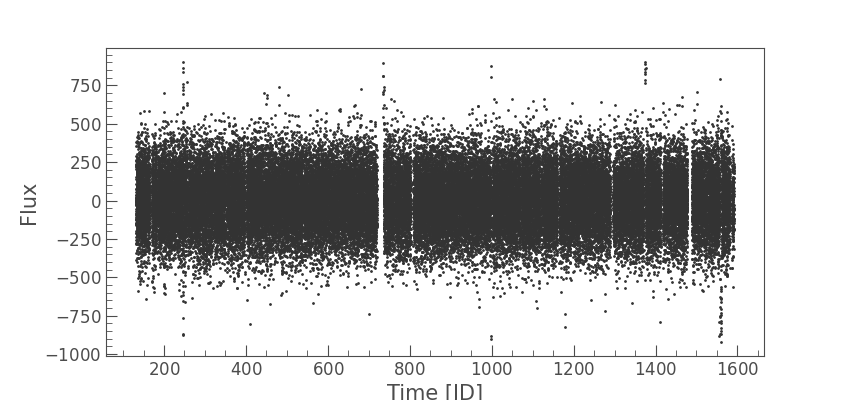

In [145]:
lc = lk.LightCurve(time=time, flux=flux, flux_err=flux_err)
lc.scatter()

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power [$\\mathrm{\\frac{1}{\\mu Hz}}$]'>

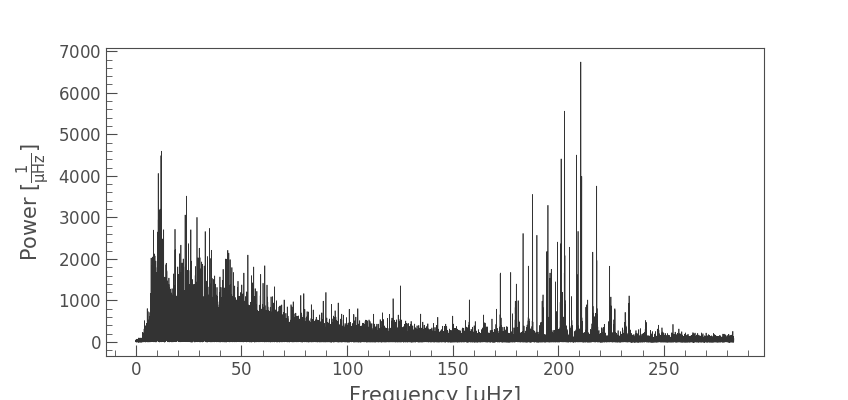

In [146]:
psd = lc.to_periodogram(normalization='psd', freq_unit='microhertz')
np.savetxt(f'{tgt}_psd.txt', np.column_stack([psd.frequency.value, psd.power.value]))
psd.plot()

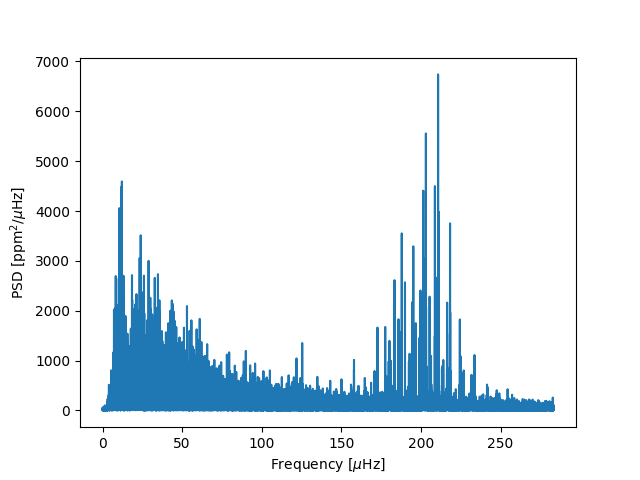

In [147]:
psd = np.genfromtxt(f'{tgt}_psd.txt')

f = psd[:,0]
s = psd[:,1]

downsampling = 1

f = f[::downsampling]

s = s[::downsampling]

fig, ax = plt.subplots()
ax.plot(f,s)
ax.set_ylabel('PSD [ppm$^2/\mu$Hz]')
ax.set_xlabel('Frequency [$\mu$Hz]')
plt.show()

In [ ]:
# IN CASE ALL FAILS
'''from pbjam import IO

tgt = 'KIC11017831'

psd = IO.psd(tgt, lk_kwargs={'exptime': 1800, 'mission':'Kepler', 'author':'Kepler'}, use_cached=True)
 
psd()

f = psd.freq

s = psd.powerdensity'''

In [148]:
README = '../../lecture-7 - solar-like oscillators/J_ApJS_215_19/ReadMe'
table3 = '../../lecture-7 - solar-like oscillators/J_ApJS_215_19/table3.dat'
table = ascii.read(table3, readme=README)
KICID = ID

numax = table['numax'][table['KIC']==KICID][0]
enumax = table['e_numax'][table['KIC']==KICID][0]
dnu = table['Dnu'][table['KIC']==KICID][0]
ednu = table['e_Dnu'][table['KIC']==KICID][0]
teff = table['Teff'][table['KIC']==KICID][0]
eteff = table['e_Teff'][table['KIC']==KICID][0]

print(numax, dnu)

# color can be accessed from https://archive.stsci.edu/kepler/kic10/search.php

addObs = {'teff' : (teff, eteff), # K
          'bp_rp': (0.793, 0.1),
          'numax': (numax, enumax), # muHz
          'dnu'  : (dnu, ednu)} # muHz

204.12 15.5


In [149]:
from pbjam.modeID import modeID
from pbjam import IO

N_p = 11
 
M = modeID(f, s, addObs, N_p=N_p)

In [150]:
M.runl20model()

16872it [02:50, 98.71it/s, +600 | bound: 173 | nc: 1 | ncall: 491171 | eff(%):  3.562 | loglstar:   -inf < -114945.359 <    inf | logz: -114973.152 +/-  0.223 | dlogz:  0.001 >  0.609]


{'ell': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2.]),
 'enn': array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,  6.,  7.,
         8.,  9., 10., 11., 12., 13., 14., 15., 16.]),
 'emm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 'zeta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 'summary': {'freq': array([[127.44483354, 142.48560712, 157.56540316, 172.68595466,
          187.84677353, 203.04952289, 218.29403314, 233.57922957,
          248.90483311, 264.27039909, 279.6757012 , 125.67382048,
          140.71417874, 155.79346087, 170.91308353, 186.07395764,
          201.27705703, 216.52248572, 231.80824281, 247.13436542,
          262.49986492, 277.9057634 ],
         [  7.46768553,   7.4994051 ,   7.52914792,   7.55652077,
            7.58205754,   7.6054419 ,   7.62558183,   7.64294632,
     

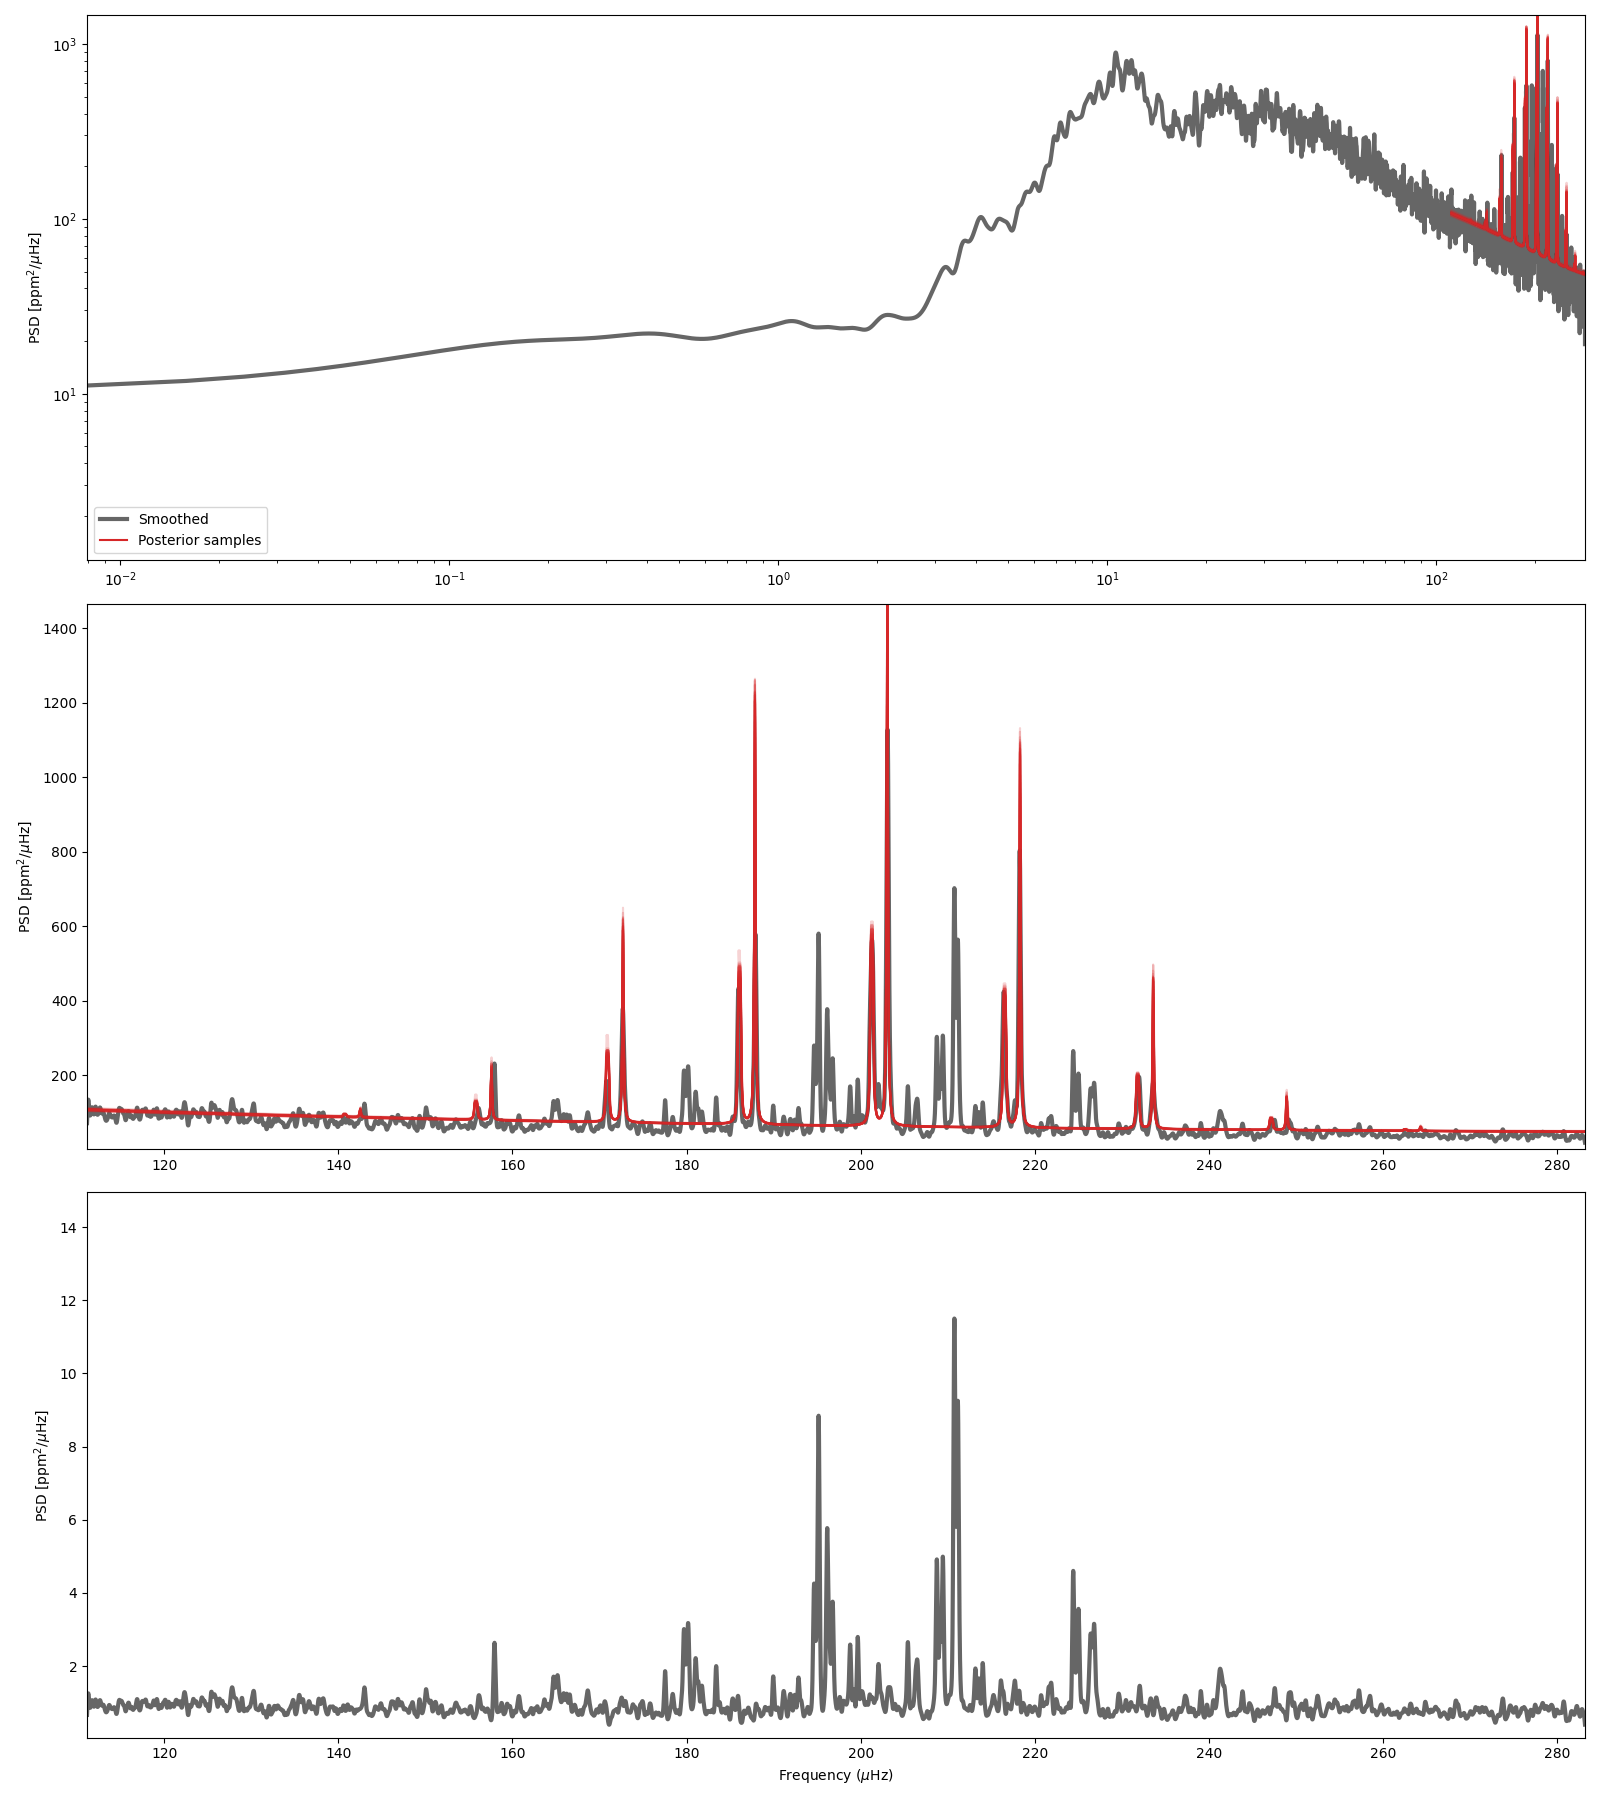

In [151]:
M.spectrum();

In [ ]:
# Might not work for RGB stars
M.runl1model(model='RGB');

(<Figure size 800x700 with 1 Axes>,
 array([<Axes: xlabel='Frequency mod 15.23 [$\\mu$Hz]', ylabel='Frequency [$\\mu$Hz]'>],
       dtype=object))

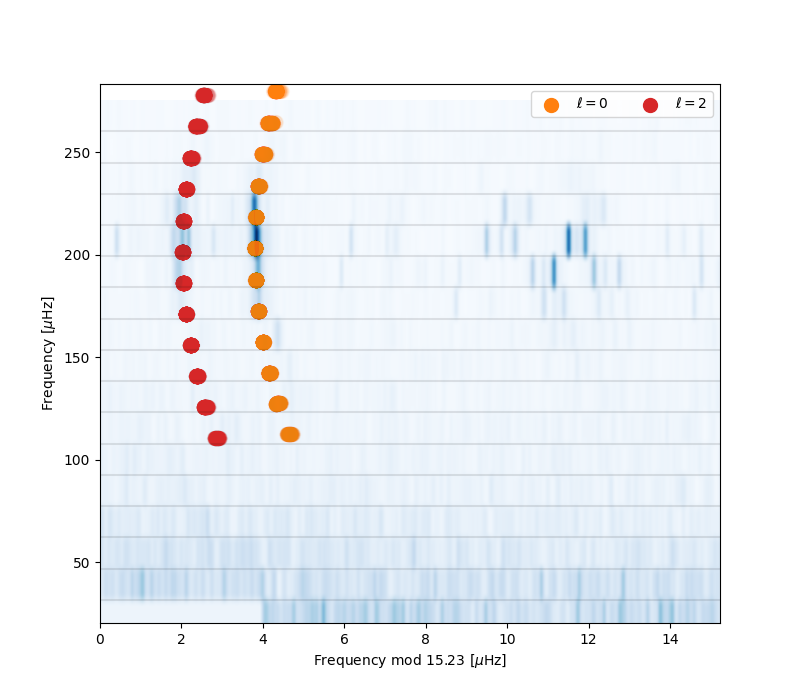

In [152]:
M.echelle()

In [153]:
from astropy.table import Table

result = M.result
print(result['summary']['freq'][0])
table = Table()
table['order'] = result['enn'].flatten().astype(int)
table['degree'] = result['ell'].flatten().astype(int)
table['frequency'] = result['summary']['freq'][0]
table['error'] = result['summary']['freq'][1]
#table['flag'] = np.ones_like(result['summary']['freq'][0])
table.sort('frequency')
table

table.write(f'../../../BASTA/data/freqs/{tgt}.fre', format='ascii.commented_header', overwrite=True)

[127.44483354 142.48560712 157.56540316 172.68595466 187.84677353
 203.04952289 218.29403314 233.57922957 248.90483311 264.27039909
 279.6757012  125.67382048 140.71417874 155.79346087 170.91308353
 186.07395764 201.27705703 216.52248572 231.80824281 247.13436542
 262.49986492 277.9057634 ]


In [158]:
from astropy.io import ascii

README = '../../lecture-7 - solar-like oscillators/J_ApJS_215_19/ReadMe'
table3 = '../../lecture-7 - solar-like oscillators/J_ApJS_215_19/table3.dat'
table = ascii.read(table3, readme=README)

KICID = ID

RA = table['RAdeg'][table['KIC']==KICID]
DEC = table['DEdeg'][table['KIC']==KICID]
numax = table['numax'][table['KIC']==KICID]
enumax = table['e_numax'][table['KIC']==KICID]
dnu = table['Dnu'][table['KIC']==KICID]
ednu = table['e_Dnu'][table['KIC']==KICID]
teff = table['Teff'][table['KIC']==KICID]
eteff = table['e_Teff'][table['KIC']==KICID]

table2 = '../../lecture-7 - solar-like oscillators/J_ApJS_215_19/table2.dat'
table = ascii.read(table2, readme=README)

feh = table['[Fe/H]'][table['KIC']==KICID]
efeh = 0.05
logg = table['log(g)'][table['KIC']==KICID]
elogg = table['e_log(g)'][table['KIC']==KICID]

In [160]:
data = {
    'starid': [KICID],
    'RA': RA,
    'DEC': DEC,
    'numax': numax,
    'enumax': enumax,
    'dnu': dnu,
    'ednu': ednu,
    'teff': teff,
    'eteff': eteff,
    'feh': feh,
    'e_feh': [efeh],
    'logg': logg,
    'elogg': elogg
}
print(data)


table_out = Table(data)

# Save to ASCII with commented header
ascii.write(table_out, f'../../../BASTA/data/KIC{ID}.ascii', 
            format='commented_header', 
            overwrite=True)

{'starid': [9635649], 'RA': <Column name='RAdeg' dtype='float64' unit='deg' description='Right Ascension in decimal degrees (J2000)' length=1>
284.769, 'DEC': <Column name='DEdeg' dtype='float64' unit='deg' description='Declination in decimal degrees (J2000)' length=1>
46.316, 'numax': <Column name='numax' dtype='float64' unit='uHz' description='[1/247] Frequency of maximum power' length=1>
204.12, 'enumax': <Column name='e_numax' dtype='float64' unit='uHz' description='Error in numax' length=1>
4.12, 'dnu': <Column name='Dnu' dtype='float64' unit='uHz' description='[0.2/18.2] Large frequency spacing {Delta}{Nu}' length=1>
15.5, 'ednu': <Column name='e_Dnu' dtype='float64' unit='uHz' description='Error in Dnu' length=1>
0.55, 'teff': <MaskedColumn name='Teff' dtype='int64' unit='K' description='Effective temperature using zero extinction (Teff-ZeroAv) (2)' length=1>
4928, 'eteff': <MaskedColumn name='e_Teff' dtype='int64' unit='K' description='Error in Teff' length=1>
90, 'feh': <Colum